<a href="https://colab.research.google.com/github/rahiakela/gans-in-action/blob/part-2-advanced-topics-in-gans/8_conditional_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN


In this notebook, you’ll learn about the **Conditional GAN (CGAN)**, which uses labels to train both the Generator and the Discriminator.
Thanks to this innovation, **a Conditional GAN allows us to direct the
Generator to synthesize the kind of fake examples we want.**

The CGAN is one of the first GAN innovations that made targeted data generation possible, and arguably the most influential one.

Conditional GAN is a generative adversarial network whose Generator and Discriminator are conditioned during training by using some additional
information. This auxiliary information could be, in theory, anything, such as a class label, a set of tags, or even a written description. 

## CGAN Generator

To formalize things a bit, let’s call the conditioning label $y$. The Generator uses the noise vector $z$ and the label $y$ to synthesize a fake example $G(z, y) = x*|y$ (read as “$x^*$ given that, or conditioned on, $y$”). The goal of this fake example is to look (in the eyes of the Discriminator) as close as possible to a real example for the given label.

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/cgan-gen.png?raw=1' width='800'/>






## CGAN Discriminator

The Discriminator receives real examples with labels $(x, y)$, and fake examples with the label used to generate them, $(x^*|y, y)$. On the real example-label pairs, the Discriminator learns how to recognize real data and how to recognize matching pairs. On the Generator-produced examples, it learns to recognize fake image-label pairs, thereby learning to tell them apart from the real ones.

The Discriminator outputs a single probability indicating its conviction that the input is a real, matching pair. The Discriminator’s goal is to learn to reject all fake examples and all examples that fail to match their label, while accepting all real example-label pairs.

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/cgan-disc.png?raw=1' width='800'/>

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/gen-disc-table.png?raw=1' width='800'/>

## Architecture

Notice that for each fake example, the same label y is passed to both the Generator and the Discriminator. Also, note that the Discriminator is never explicitly trained to reject mismatched pairs by being trained on real examples with mismatching labels; its ability to identify mismatched pairs is a by-product of being trained to accept only real matching pairs.

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/cgan-arc.png?raw=1' width='800'/>

The CGAN Discriminator receives fake labeled examples $(x^*|y, y)$ produced by the Generator and real labeled examples $(x, y)$, and it learns to tell whether a given example-label is real or fake.



## Implementing a Conditional GAN

We will implement a CGAN model that learns to generate handwritten
digits of our choice. At the end, we will generate a sample of images for each numeral to see how well the model learned to generate targeted data.



### Setup

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense, Dropout, Embedding,
                                     Flatten, Input, Reshape, Multiply, LeakyReLU, Conv2D, Conv2DTranspose)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We also specify the input image size, the size of the noise vector $z$, and the number of the real classes.

In [2]:
# Model input dimensions
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

### CGAN Generator

The modifications made for the CGAN center around input handling, where we use embedding and element-wise multiplication to combine the random noise vector z and the label y into a joint representation.

1. Take label y (an integer from 0 to 9) and turn it into a dense vector of size z_dim (the length of the random noise vector) by using the Keras Embedding layer.
2. Combine the label embedding with the noise vector z into a joint representation by using the Keras Multiply layer. As its name suggests, this layer multiplies the corresponding entries of the two equal-length vectors and outputs a single vector of the resulting products.
3. Feed the resulting vector as input into the rest of the CGAN Generator network to synthesize an image.

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/cgan-combine.png?raw=1' width='800'/>

First, we embed the label into a vector of the same size as $z$. Second, we multiply the corresponding elements of the embedded label and $z$ (the symbol $\odot$ denotes element-wise multiplication). The resulting joined representation is then used as input into the CGAN Generator network.

In [3]:
def build_generator(z_dim):
  model = Sequential()

  # Reshape input into 7x7x256 tensor via a fully connected layer
  model.add(Dense(256 * 7 * 7, input_dim=z_dim))
  model.add(Reshape((7, 7, 256)))

  # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
  # Batch normalization
  model.add(BatchNormalization())
  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
  # Batch normalization
  model.add(BatchNormalization())
  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

  # utput layer with tanh activation
  model.add(Activation('tanh'))

  return model

def build_cgan_generator(z_dim):
  # Random noise vector z
  z = Input(shape=(z_dim, ))

  # Conditioning label: integer 0-9 specifying the number G should generate
  label = Input(shape=(1, ), dtype='int32')

  # Label embedding:
  # ----------------
  # Turns labels into dense vectors of size z_dim
  # Produces 3D tensor with shape (batch_size, 1, z_dim)
  label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

  # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, z_dim)
  label_embedding = Flatten()(label_embedding)

  # Element-wise product of the vectors z and the label embeddings
  joined_representation = Multiply()([z, label_embedding])

  generator = build_generator(z_dim)

  # Generate image for the given label
  conditioned_img = generator(joined_representation)

  return Model([z, label], conditioned_img)

### CGAN Discriminator

Next, we implement the CGAN Discriminator.Here, we use the Keras Embedding layer to turn input labels into dense vectors. However, unlike the Generator, where the model input is a flat vector, the Discriminator receives three-dimensional images. This necessitates customized handling, described in the following steps:

1. Take a label (an integer from 0 to 9) and—using the Keras Embedding layer—turn the label into a dense vector of size 28 × 28 × 1 = 784 (the length of a flattened image).
2. Reshape the label embeddings into the image dimensions (28 × 28 × 1).
3. Concatenate the reshaped label embedding onto the corresponding image,
creating a joint representation with the shape (28 × 28 × 2). You can think of it as an image with its embedded label “stamped” on top of it.
4. Feed the image-label joint representation as input into the CGAN Discriminator network. Note that in order for things to work, we have to adjust the model input dimensions to (28 × 28 × 2) to reflect the new input shape.

Again, to make it less abstract, let’s see what the process looks like visually, using the label 7 as an example.

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/combine-label-image.png?raw=1' width='800'/>

First, we embed the label into a vector the size of a flattened image (28 × 28 × 1 = 784).

Second, we reshape the embedded label into a tensor with the same shape as the input image (28 × 28 × 1). 

Third, we concatenate the reshaped label that is embedding onto the corresponding image. This joined representation is then passed as
input into the CGAN Discriminator network.

In addition to the preprocessing steps, we have to make a few additional adjustments to the Discriminator network:

1. First, we have to adjust the model input dimensions to (28 × 28 × 2) to reflect the new input shape.
2. Second, we increase the depth of the first convolutional layer from 32 to 64. The reasoning behind this change is that there is more information to encode because of the concatenated label embedding; this network architecture indeed yielded better results experimentally.

At the output layer, we use the sigmoid activation function to produce a probability that the input image-label pair is real rather than fake—no change here.

In [13]:
def build_discriminator(img_shape):
  model = Sequential()

  # Convolutional layer, from 28x28x1 into 14x14x32 tensor
  model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1), padding='same'))
  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Convolutional layer, from 14x14x64 tensor into 7x7x64 tensor
  model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  # Batch normalization
  model.add(BatchNormalization())
  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
  model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  # Batch normalization
  model.add(BatchNormalization())
  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Flatten the tensor
  model.add(Flatten())

  # Fully connected layer with sigmoid activation
  model.add(Dense(1, activation='sigmoid'))

  return model

def build_cgan_discriminator(img_shape):
  # Input image
  img = Input(shape=img_shape)

  # Label for the input image
  label = Input(shape=(1, ), dtype='int32')

  # Label embedding:
  # ----------------
  # Turns labels into dense vectors of size z_dim
  # Produces 3D tensor with shape (batch_size, 1, 28*28*1)
  label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)

  # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, 28*28*1)
  label_embedding = Flatten()(label_embedding)

  # Reshape label embeddings to have same dimensions as input images
  label_embedding = Reshape(img_shape)(label_embedding)

  # Concatenate images with their label embeddings
  concatenated = Concatenate(axis=-1)([img, label_embedding])

  discriminator = build_discriminator(img_shape)

  # Classify the image-label pair
  classification = discriminator(concatenated)

  return Model([img, label], classification)

### Building the model

Next, we build and compile the CGAN Discriminator and Generator models, as shown in the following listing. Notice that in the combined model used to train the Generator, the same input label is passed to the Generator (to generate a sample) and to the Discriminator (to make a prediction).

In [9]:
def build_cgan(generator, discriminator):

  # Random noise vector z
  z = Input(shape=(z_dim, ))

  # Image label
  label = Input(shape=(1, ))
  
  # Generated image for that label
  img = generator([z, label])

  classification = discriminator([img, label])

  # Combined Generator -> Discriminator model
  # G([z, lablel]) = x*
  # D(x*) = classification
  model = Model([z, label], classification)

  return model

In [14]:
# Builds and compiles the Discriminator for supervised training
discriminator  = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Builds the Generator
generator = build_cgan_generator(z_dim)

# Keeps Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Builds and compiles GAN model with fixed Discriminator to train the Generator.
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

### Training

The following pseudocode outlines the CGAN training algorithm.

**CGAN training algorithm**

**For** each training iteration **do**
  1. Train the Discriminator:
    - Take a random mini-batch of labeled real examples $(x, y)$.
    - Compute $D((x, y))$ for the given mini-batch and backpropagate the  multiclass classification loss to update $\theta^{(D)}$ to minimize the loss.
    - Take a mini-batch of random noise vectors and class labels $(z, y)$ and generate a mini-batch of fake examples: $G(z, y) = x*|y$.
    - Compute $D(x^*|y, y)$ for the mini-batch and backpropagate the binary classification loss to update $\theta^{(D)}$ to minimize the loss.
  
  2. Train the Generator:
    - Take a mini-batch of random noise vectors and class labels $(z, y)$ and generate a mini-batch of fake examples: $G(z, y) = x^*|y$.
    - Compute $D(x^*|y, y)$ for the given mini-batch and backpropagate the binary
  classification loss to update $\theta^{(G)}$ to maximize the loss.
  
**End for**

In [19]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
  # Load the MNIST dataset
  (X_train, y_train), (_, _) = mnist.load_data()

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train  = X_train / 127.5 - 1.
  X_train = np.expand_dims(X_train, axis=3)

  # Labels for real images: all ones
  real = np.ones((batch_size, 1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    # -------------------------
    #  Train the Discriminator
    # -------------------------

    # Get a random batch of real images and their labels
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict([z, labels])

    # Train the Discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], real)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train the Generator
    # ---------------------

    # Generate a batch of noise vectors
    z = np.random.normal(0, 1, (batch_size, z_dim))
    # Get a batch of random labels
    labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

    # Trains the Generator
    g_loss = cgan.train_on_batch([z, labels], real)

    if (iteration + 1) % sample_interval == 0:
      #Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))
      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])

      # Output sample of generated images
      sample_images()

### Outputting sample images

First, instead of a 4 × 4 grid of random handwritten digits, we are generating a 2 × 5 grid of numbers, 1 through 5 in the first row, and 6 through 9 in the second row. This allows us to inspect how well the CGAN Generator is learning to produce specific numerals. Second, we are displaying the label for each example by using the set_title() method.

In [17]:
def sample_images(image_grid_rows=2, image_grid_columns=5):
  # Sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # Get image labels 0-9
  labels = np.arange(0, 10).reshape(-1, 1)

  # Generate images from random noise
  gen_imgs = generator.predict([z, labels])

  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Set image grid
  fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 4), sharey=True, sharex=True)

  cnt = 0
  for i in range(image_grid_rows):
      for j in range(image_grid_columns):
          # Output a grid of images
          axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
          axs[i, j].axis('off')
          axs[i, j].set_title("Digit: %d" % labels[cnt])
          cnt += 1

### Train the Model and Inspect Training Progress

Note that the 'Discrepancy between trainable weights and collected trainable' warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

1000 [D loss: 0.001371, acc.: 100.00%] [G loss: 0.022533]
2000 [D loss: 0.000323, acc.: 100.00%] [G loss: 0.000787]
3000 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.000152]
4000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.000056]
5000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000052]
6000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000040]
7000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000028]
8000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000020]
9000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000013]
10000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000009]
11000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000005]
12000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000004]


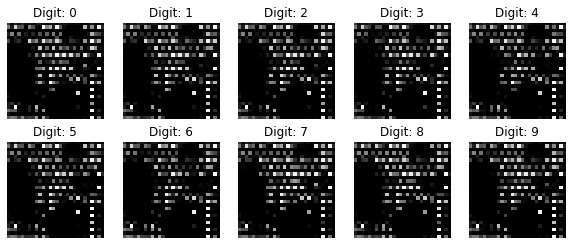

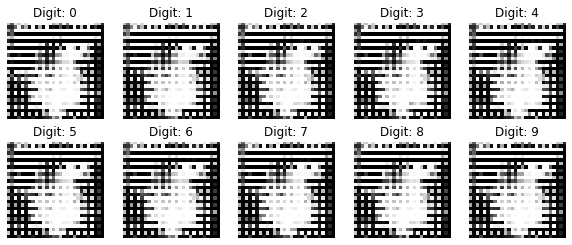

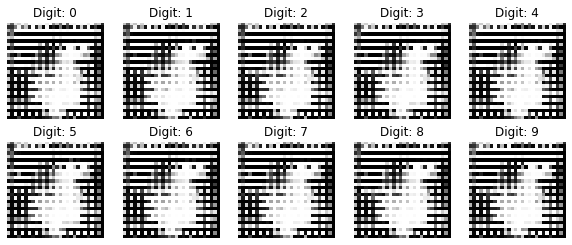

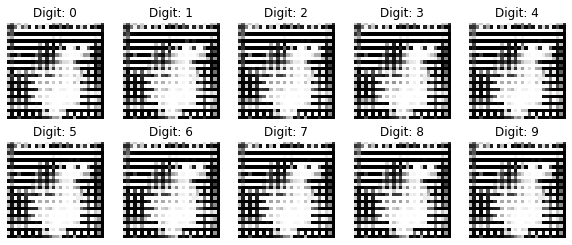

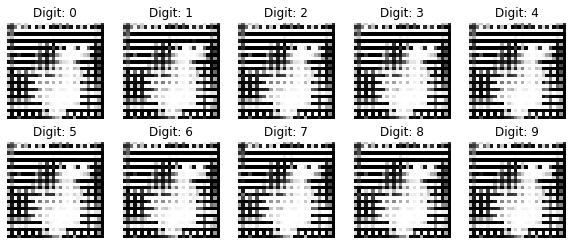

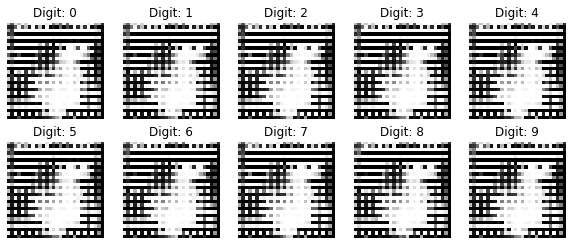

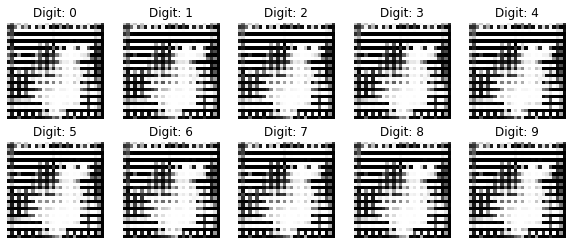

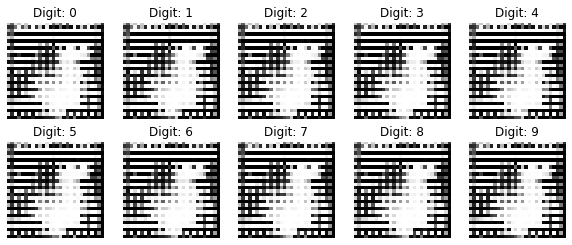

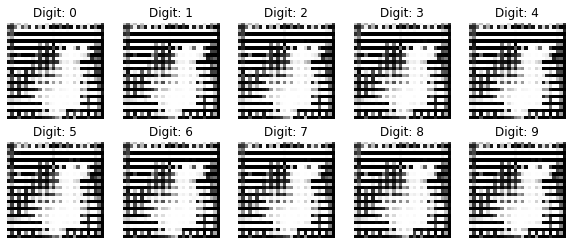

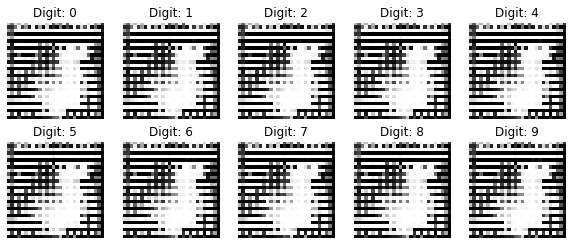

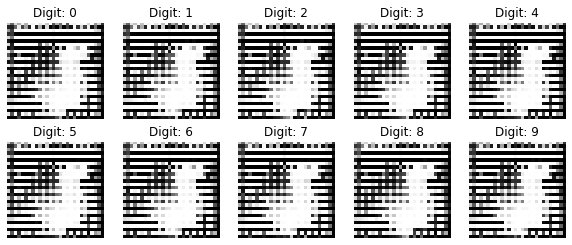

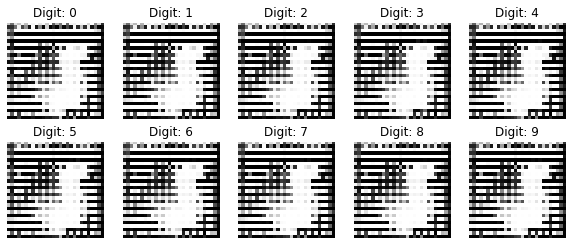

In [20]:
# sets hyperparameters
iterations = 12000
batch_size = 32
sample_interval = 1000

# Train the CGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

### Inspecting the output: Targeted data generation

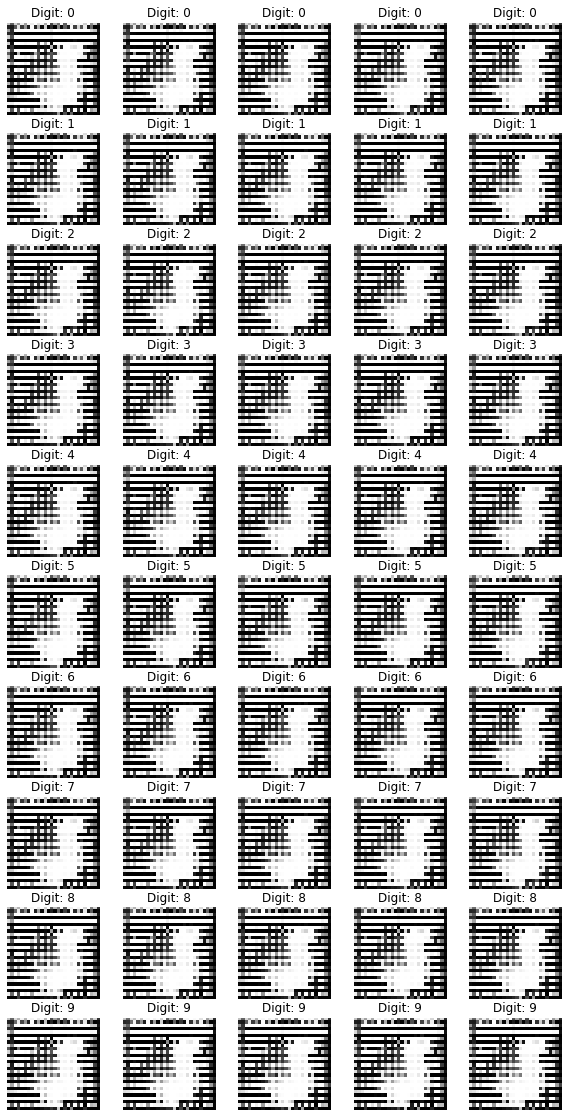

In [21]:
# Set grid dimensions
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Get image labels to generate: 5 samples for each label
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# Generate images from random noise
gen_imgs = generator.predict([z, labels_to_generate])

# Rescale image pixel values to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output a grid of images
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1

The images of digits produced by the CGAN Generator after it is fully
trained. At each row, we instruct the Generator to synthesize a different numeral, from 0 to 9. Notice that each numeral is rendered in a different writing style, attesting to CGAN’s ability not only to learn to produce examples matching every label in the training dataset, but also to capture the full diversity of the training data.

Along with the DCGAN, CGAN is one of the most influential early GAN variants that has inspired countless new research directions.

Perhaps the most impactful and promising of these is the use of conditional adversarial networks as a general-purpose solution to image-to-image translation problems. This is a class of problems that seeks to translate images from one modality into another. Applications of image-to-image translation range from colorizing black-andwhite photos to turning a daytime scene into nighttime and synthesizing a satellite
view from a map view.

One of the most successful early implementations based on the Conditional GAN paradigm is pix2pix, which uses pairs of images (one as the input and the other as the label) to learn to translate from one domain into another. Recall that, in theory as well as in practice, the conditioning information used to train a CGAN can be much more than just labels to provide for more complex use cases and scenarios.

But CycleGAN outperformed pix2pix’s performance on image-to-image translation tasks and also accomplished it without the need for paired images.

The Cycle-Consistent Adversarial Network (or CycleGAN) needs only two groups of images representing the two domains(a group of black-and-white photos and a group of colored photos).